# Bayesian Optimization

This notebook demonstrates how to use alabi for Bayesian optimization on a 1D multimodal function using the Jones (Expected Improvement) active learning algorithm.

## Import Libraries

First, let's import the necessary libraries:

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from alabi.core import SurrogateModel
import warnings
warnings.filterwarnings('ignore')

np.random.seed(99)

## Define the Multimodal Test Function

We'll use a 1D multimodal function with multiple local maxima. This function combines a sine wave with a Gaussian peak to create an interesting optimization landscape:

In [32]:
def multimodal_function(theta):
    """
    A 1D multimodal function with multiple peaks.
    Global maximum is around x=1.5
    """
    x = theta[0] if hasattr(theta, '__len__') else theta
    
    # Combine sine wave with Gaussian peaks
    f1 = 3 * np.sin(2 * np.pi * x) * np.exp(-0.5 * x**2)
    f2 = 2 * np.exp(-2 * (x - 1.5)**2)
    f3 = 1.5 * np.exp(-3 * (x + 0.5)**2)
    
    return f1 + f2 + f3

def plot_function(x_plot, y_plot):
    fig = plt.figure(figsize=(10, 6))
    plt.plot(x_plot, y_plot, 'k-', linewidth=2, label='True function')
    plt.scatter(x_plot[np.argmax(y_plot)], np.max(y_plot), color='red', s=100, label='Global Maximum')
    plt.xlabel('x', fontsize=14)
    plt.ylabel('f(x)', fontsize=14)
    plt.title('1D Multimodal Function', fontsize=16)
    plt.grid(True, alpha=0.3)
    plt.legend()

    print(f"True global maximum at x={x_plot[np.argmax(y_plot)]:.3f} with f(x)={np.max(y_plot):.3f}")
    
    return fig

True global maximum at x=-0.712 with f(x)=3.573


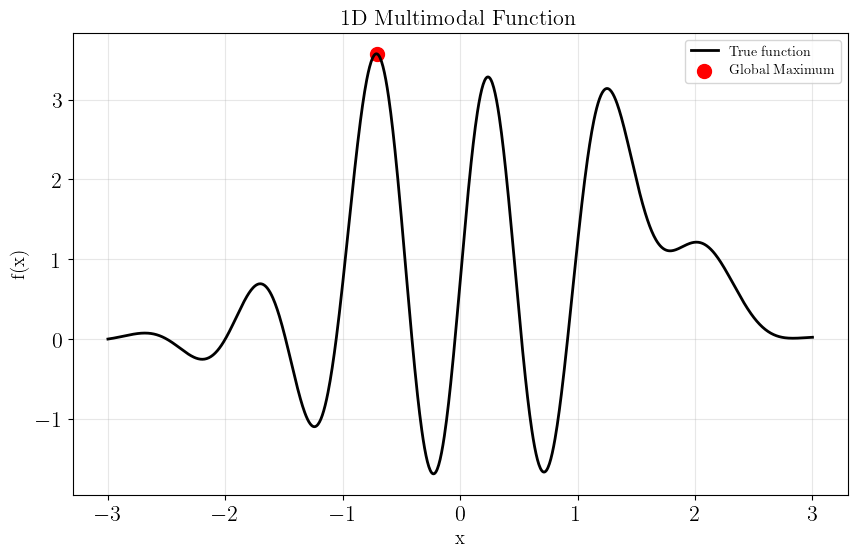

In [33]:
# Visualize the function
x_plot = np.linspace(-3, 3, 1000)
y_plot = [multimodal_function(x) for x in x_plot]

fig = plot_function(x_plot, y_plot)

## Set up the Surrogate Model

Now we'll create a SurrogateModel using alabi. For optimization, we want to maximize the function, but alabi works with log-likelihood functions (which we typically want to maximize). So we'll use our function directly as the "log-likelihood".

In [42]:
# Define bounds for the parameter space
bounds = [(-3.0, 3.0)]  

# Create the surrogate model
sm = SurrogateModel(
    lnlike_fn=multimodal_function,
    bounds=bounds,
    param_names=['x'],
    cache=False,  # Disable caching for this demo
    verbose=True
)

## Initialize Training Set

Start with a small set of initial training points. First we'll try training `alabi` with the default GP settings (using the squared exponential kernel and log-length scales ranging [-2,2]).

In [77]:
# Initialize with a few random points
sm.init_samples(ntrain=10, sampler='sobol')

gp_kwargs = {"kernel": "ExpSquaredKernel",
             "fit_amp": True,
             "fit_mean": True,
             "fit_white_noise": False,
             "white_noise": -12,
             "gp_opt_method": "l-bfgs-b",
             "gp_scale_rng": [-2,2],
             "optimizer_kwargs": {"max_iter": 50},
             "overwrite": True}

sm.init_gp(**gp_kwargs)

Computed 10 function evaluations: 5.0s 

Initialized GP with squared exponential kernel.
Successfully initialized GP on attempt 1
Optimized 3 hyperparameters: (0.018s)


True global maximum at x=-0.712 with f(x)=3.573


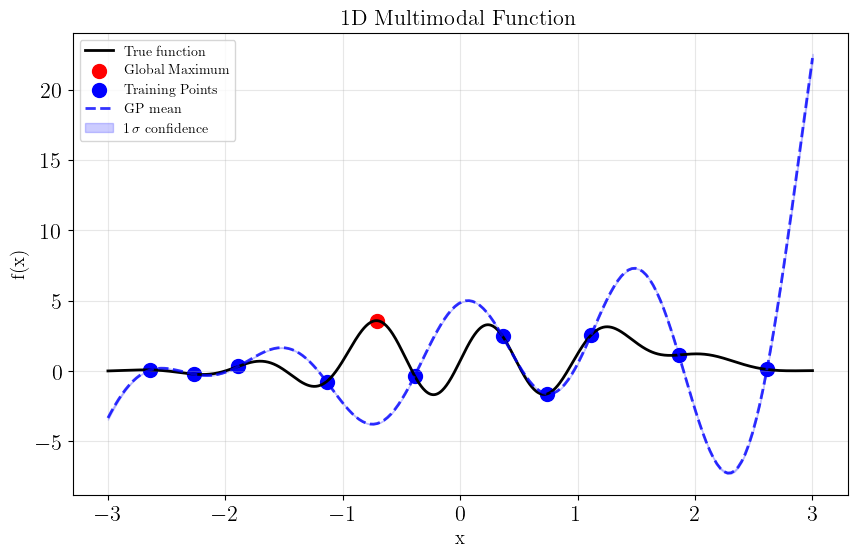

In [78]:
xpred = np.linspace(-3, 3, 200).reshape(-1,1)
ypred, yvar = sm.surrogate_log_likelihood(xpred, return_var=True)
ystd = np.sqrt(yvar)

fig = plot_function(x_plot, y_plot)
plt.scatter(sm.theta0, sm.y0, color='blue', s=100, label='Training Points')
plt.plot(xpred.flatten(), ypred, 'b--', linewidth=2, label='GP mean', alpha=0.8)
plt.fill_between(xpred.flatten(), ypred - ystd, ypred + ystd, 
                 color='b', alpha=0.2, label=f'$1\,\sigma$ confidence')
plt.legend()
plt.show()

The fit is not great--we notice that the GP fit has regions with high error and low prediction uncertainty. We can instead try a more flexible kernel by choosing the Matern-3/2 kernel with a lower bound on scale lengths [-4,2] and see if it performs better.

In [79]:
# Initialize with a few random points
sm.init_samples(ntrain=10, sampler='sobol')

gp_kwargs = {"kernel": "Matern32Kernel",
             "fit_amp": True,
             "fit_mean": True,
             "fit_white_noise": False,
             "white_noise": -12,
             "gp_opt_method": "l-bfgs-b",
             "gp_scale_rng": [-4,2],
             "optimizer_kwargs": {"max_iter": 50},
             "overwrite": True}

sm.init_gp(**gp_kwargs)

Computed 10 function evaluations: 5.0s 

Initialized GP with Matérn-3/2 kernel.
Successfully initialized GP on attempt 1
Optimized 3 hyperparameters: (0.026s)


True global maximum at x=-0.712 with f(x)=3.573


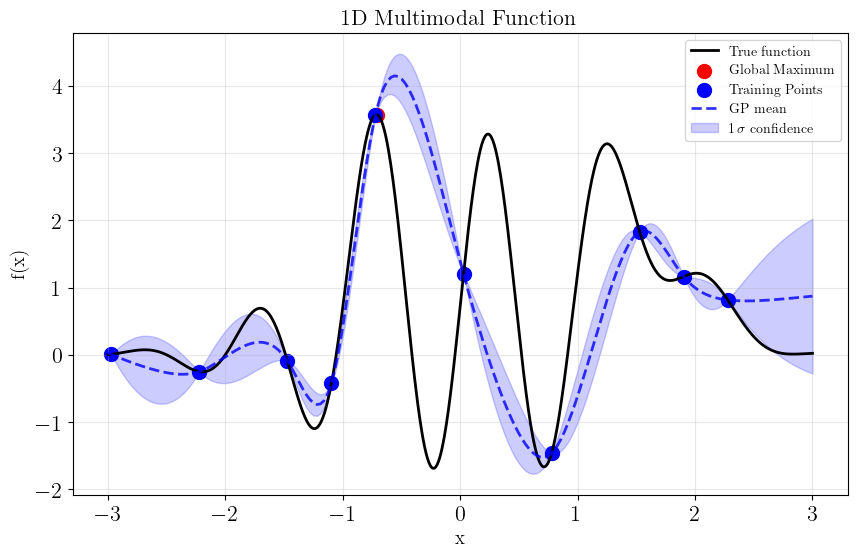

In [80]:
xpred = np.linspace(-3, 3, 200).reshape(-1,1)
ypred, yvar = sm.surrogate_log_likelihood(xpred, return_var=True)
ystd = np.sqrt(yvar)

fig = plot_function(x_plot, y_plot)
plt.scatter(sm.theta0, sm.y0, color='blue', s=100, label='Training Points')
plt.plot(xpred.flatten(), ypred, 'b--', linewidth=2, label='GP mean', alpha=0.8)
plt.fill_between(xpred.flatten(), ypred - ystd, ypred + ystd, 
                 color='b', alpha=0.2, label=f'$1\,\sigma$ confidence')
plt.legend()
plt.show()

This prediction is a bit better, but still needs work, so we can train more samples with active learning.

## Run Bayesian Optimization with Jones Algorithm

The Jones algorithm (Expected Improvement) is designed for optimization. It balances exploration (uncertainty) with exploitation (improving the current best).

In [81]:
# Run active learning with Jones algorithm
niter = 30
sm.active_train(
    niter=niter,
    algorithm="jones",  # Use Jones (Expected Improvement) algorithm
    gp_opt_freq=5,     # Re-optimize GP hyperparameters every 5 iterations
)

Running 30 active learning iterations using jones...


 17%|█▋        | 5/30 [00:00<00:02,  8.77it/s]

Optimized 3 hyperparameters: (0.028s)


 33%|███▎      | 10/30 [00:01<00:02,  9.24it/s]

Optimized 3 hyperparameters: (0.012s)


 47%|████▋     | 14/30 [00:01<00:01, 10.29it/s]

Optimized 3 hyperparameters: (0.011s)


 67%|██████▋   | 20/30 [00:02<00:01,  9.29it/s]

Optimized 3 hyperparameters: (0.024s)


 80%|████████  | 24/30 [00:02<00:00, 10.32it/s]

Optimized 3 hyperparameters: (0.065s)


100%|██████████| 30/30 [00:03<00:00,  9.25it/s]

Optimized 3 hyperparameters: (0.119s)


True global maximum at x=-0.712 with f(x)=3.573


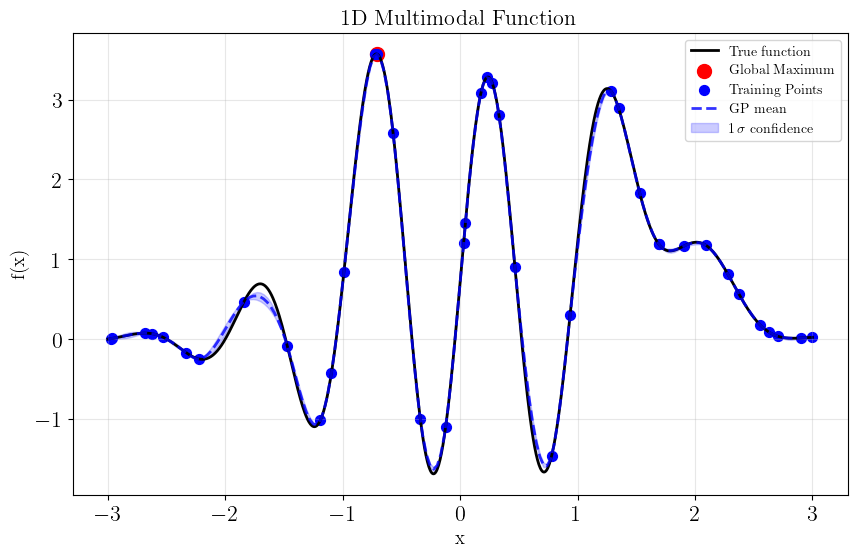

In [82]:
xpred = np.linspace(-3, 3, 200).reshape(-1,1)
ypred, yvar = sm.surrogate_log_likelihood(xpred, return_var=True)
ystd = np.sqrt(yvar)

fig = plot_function(x_plot, y_plot)
plt.scatter(sm.theta(), sm.y(), color='blue', s=50, label='Training Points')
plt.plot(xpred.flatten(), ypred, 'b--', linewidth=2, label='GP mean', alpha=0.8)
plt.fill_between(xpred.flatten(), ypred - ystd, ypred + ystd, 
                 color='b', alpha=0.2, label=f'$1\,\sigma$ confidence')
plt.legend()
plt.show()

## Visualize the Optimization Process

Let's create a visualization showing the true function, the GP surrogate model, and the points selected by the Jones algorithm.

In [83]:
# Get GP predictions over the domain
xpred = np.linspace(-3, 3, 200).reshape(-1,1)

x_best_iter, y_best_iter = [], []
for it in range(sm.nactive):
    ypred, yvar = sm.surrogate_log_likelihood(xpred, iter=it, return_var=True)
    ystd = np.sqrt(yvar)

    best_idx = np.argmax(ypred)
    best_x = xpred[best_idx]
    best_f = ypred[best_idx]
    
    x_best_iter.append(best_x)
    y_best_iter.append(best_f)

true_optimum_idx = np.argmax(y_plot)
true_optimum_x = x_plot[true_optimum_idx]
true_optimum_f = y_plot[true_optimum_idx]

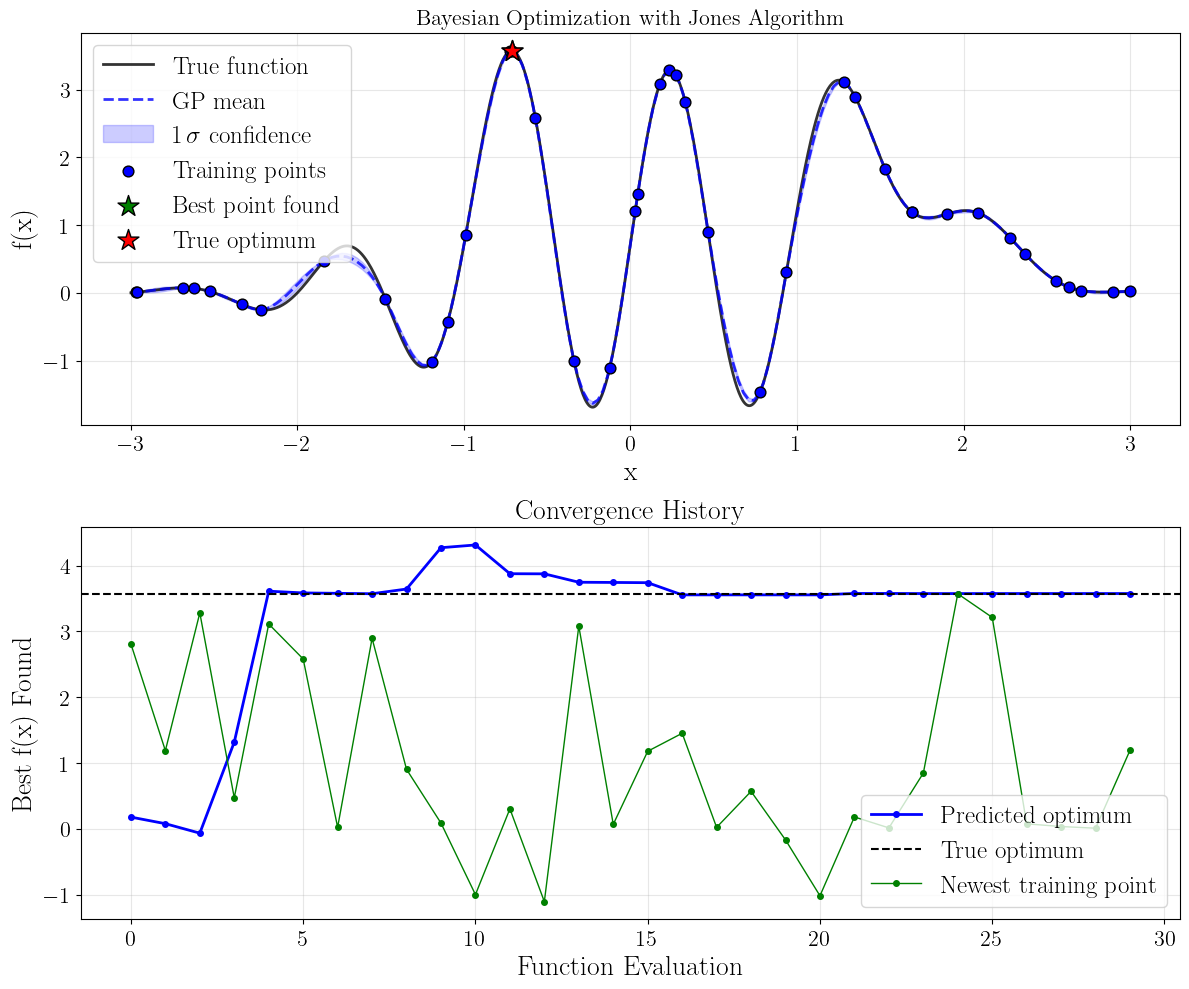

In [84]:
# Final iteration prediction
ypred, yvar = sm.surrogate_log_likelihood(xpred, iter=-1, return_var=True)
ystd = np.sqrt(yvar)

plt.figure(figsize=(12,10))

# Plot true function
plt.subplot(2, 1, 1)
plt.plot(x_plot, y_plot, 'k-', linewidth=2, label='True function', alpha=0.8)

# Plot GP mean and uncertainty
plt.plot(xpred.flatten(), ypred, 'b--', linewidth=2, label='GP mean', alpha=0.8)
plt.fill_between(xpred.flatten(), ypred - ystd, ypred + ystd, 
                 color='b', alpha=0.2, label=f'$1\,\sigma$ confidence')

# Plot training points
plt.scatter(sm.theta(), sm.y(), 
           c='b', s=60, zorder=5, label='Training points', edgecolor='black')

# Highlight the best point
plt.scatter(best_x, best_f, c='green', s=250, marker='*', 
           zorder=6, label='Best point found', edgecolor='black')

# Highlight true optimum
plt.scatter(true_optimum_x, true_optimum_f, c='red', s=250, marker='*', 
           zorder=6, label='True optimum', edgecolor='black')

plt.xlabel('x', fontsize=20)
plt.ylabel('f(x)', fontsize=20)
plt.title('Bayesian Optimization with Jones Algorithm', fontsize=16)
plt.legend(loc='upper left', fontsize=18)
plt.grid(True, alpha=0.3)

# Plot convergence history
plt.subplot(2, 1, 2)
plt.plot(range(len(y_best_iter)), y_best_iter, 'b-o', linewidth=2, markersize=4, label="Predicted optimum")
plt.axhline(y=true_optimum_f, color='k', linestyle='--', label='True optimum')
plt.plot(range(sm.nactive), sm.y()[sm.ninit_train:], "g-o", linewidth=1, markersize=4, label="Newest training point")
plt.xlabel('Function Evaluation', fontsize=20)
plt.ylabel('Best f(x) Found', fontsize=20)
plt.title('Convergence History', fontsize=20)
plt.legend(loc="lower right", fontsize=18)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Summary

This example demonstrates how to use alabi for Bayesian optimization:

1. **Problem Setup**: We defined a 1D multimodal function with multiple local maxima
2. **Surrogate Model**: Created a `SurrogateModel` with the function and parameter bounds
3. **Initialization**: Started with a small set of random training points
4. **Optimization**: Used the Jones algorithm (Expected Improvement) to iteratively select new points
5. **Results**: The algorithm successfully found the global maximum with high accuracy

The Jones algorithm is particularly effective for optimization because it:
- **Exploits** known good regions (high function values)
- **Explores** uncertain regions (high GP variance)
- **Balances** these two objectives through the Expected Improvement criterion

This approach is much more efficient than random search or grid search, especially for expensive function evaluations.

### Things to try next:

- Different kernel functions (`ExpSquaredKernel`, `Matern32Kernel`, `Matern52Kernel`)
- Increase the number of training samples
- Run multiple trials for each setting to test how robust the training is to random sampling